# Fine-tuning Stable Diffusion

# Introduction

This tutorial shows how to fine-tune a
[Stable Diffusion model](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/)
on a custom dataset of `{image, caption}` pairs. We build on top of the fine-tuning
script provided by Hugging Face

We assume that you have a high-level understanding of the Stable Diffusion model.
The following resources can be helpful if you're looking for more information in that regard:

* [High-performance image generation using Stable Diffusion in KerasCV](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/)
* [Stable Diffusion with Diffusers](https://huggingface.co/blog/stable_diffusion)

It's highly recommended that you use a GPU with at least 30GB of memory to execute
the code.


In [1]:
!pip install wurlitzer

In [2]:
!pip install keras-cv==0.6.0 tensorflow==2.15.0 keras-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.3/756.3 kB 5.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: keras-cv
    Found existing installation: keras-cv 0.9.0
    Uninstalling keras-cv-0.9.0:
      Successfully uninstalled keras-cv-0.9.0


## What are we fine-tuning?

A Stable Diffusion model can be decomposed into several key models:

* A text encoder that projects the input prompt to a latent space. (The caption
associated with an image is referred to as the "prompt".)
* A variational autoencoder (VAE) that projects an input image to a latent space acting
as an image vector space.
* A diffusion model that refines a latent vector and produces another latent vector, conditioned
on the encoded text prompt
* A decoder that generates images given a latent vector from the diffusion model.

It's worth noting that during the process of generating an image from a text prompt, the
image encoder is not typically employed.

However, during the process of fine-tuning, the workflow goes like the following:

1. An input text prompt is projected to a latent space by the text encoder.
2. An input image is projected to a latent space by the image encoder portion of the VAE.
3. A small amount of noise is added to the image latent vector for a given timestep.
4. The diffusion model uses latent vectors from these two spaces along with a timestep embedding
to predict the noise that was added to the image latent.
5. A reconstruction loss is calculated between the predicted noise and the original noise
added in step 3.
6. Finally, the diffusion model parameters are optimized w.r.t this loss using
gradient descent.

Note that only the diffusion model parameters are updated during fine-tuning, while the
(pre-trained) text and the image encoders are kept frozen.

Don't worry if this sounds complicated. The code is much simpler than this!

In [3]:
from textwrap import wrap
import os

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras

2024-06-16 18:08:24.505887: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 18:08:24.506036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 18:08:24.604197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


## Data loading

We use the dataset
[Pokémon BLIP captions](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions).
However, we'll use a slightly different version which was derived from the original
dataset to fit better with `tf.data`. Refer to
[the documentation](https://huggingface.co/datasets/sayakpaul/pokemon-blip-original-version)
for more details.

In [4]:
data_path = tf.keras.utils.get_file(
    origin = "https://huggingface.co/datasets/sayakpaul/pokemon-blip-original-version/resolve/main/pokemon_dataset.tar.gz",
    untar = True,
)
data_frame = pd.read_csv(os.path.join(data_path, 'data.csv'))

347504640/347504640 [==============================] - 6s 0us/step


In [5]:
data_frame['image_path'] = data_frame['image_path'].apply(
    lambda x: os.path.join(data_path, x))

In [6]:
data_frame.head()

,image_path,caption
0,/root/.keras/datasets/pokemon_dataset/image_0.png,a drawing of a green pokemon with red eyes
1,/root/.keras/datasets/pokemon_dataset/image_1.png,a green and yellow toy with a red nose
2,/root/.keras/datasets/pokemon_dataset/image_2.png,a red and white ball with an angry look on its...
3,/root/.keras/datasets/pokemon_dataset/image_3.png,a cartoon ball with a smile on it's face
4,/root/.keras/datasets/pokemon_dataset/image_4.png,a bunch of balls with faces drawn on them


Since we have only 833 `{image, caption}` pairs, we can precompute the text embeddings from
the captions. Moreover, the text encoder will be kept frozen during the course of
fine-tuning, so we can save some compute by doing this.

Before we use the text encoder, we need to tokenize the captions.

In [7]:
# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

#  Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(data_frame), MAX_PROMPT_LENGTH))

all_captions = list(data_frame["caption"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)

1356917/1356917 [==============================] - 0s 0us/step


In [8]:
all_captions[:4]

['a drawing of a green pokemon with red eyes',
 'a green and yellow toy with a red nose',
 'a red and white ball with an angry look on its face',
 "a cartoon ball with a smile on it's face"]

## Prepare a `tf.data.Dataset`

In this section, we'll prepare a `tf.data.Dataset` object from the input image file paths
and their corresponding caption tokens. The section will include the following:

* Pre-computation of the text embeddings from the tokenized captions.
* Loading and augmentation of the input images.
* Shuffling and batching of the dataset.

In [9]:
RESOLUTION = 256
AUTO = tf.data.AUTOTUNE
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(RESOLUTION, RESOLUTION),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)
text_encoder = TextEncoder(MAX_PROMPT_LENGTH)


def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text


def apply_augmentation(image_batch, token_batch):
    return augmenter(image_batch), token_batch


def run_text_encoder(image_batch, token_batch):
    return (
        image_batch,
        token_batch,
        text_encoder([token_batch, POS_IDS], training=False),
    )


def prepare_dict(image_batch, token_batch, encoded_text_batch):
    return {
        "images": image_batch,
        "tokens": token_batch,
        "encoded_text": encoded_text_batch,
    }


def prepare_dataset(image_paths, tokenized_texts, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tokenized_texts))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(run_text_encoder, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_dict, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)


492466864/492466864 [==============================] - 2s 0us/step


The baseline Stable Diffusion model was trained using images with 512x512 resolution. It's
unlikely for a model that's trained using higher-resolution images to transfer well to
lower-resolution images. However, the current model will lead to OOM if we keep the
resolution to 512x512 (without enabling mixed-precision). Therefore, in the interest of
interactive demonstrations, we kept the input resolution to 256x256.

In [10]:
# prepare dataset
training_dataset = prepare_dataset(
    np.array(data_frame['image_path']), tokenized_texts , batch_size =4
)

# take a sample batch and investigate
sample_batch = next(iter(training_dataset))



for k in sample_batch:
    print(k, sample_batch[k].shape)

images (4, 256, 256, 3)
tokens (4, 77)
encoded_text (4, 77, 768)


We can also take a look at the training images and their corresponding captions.

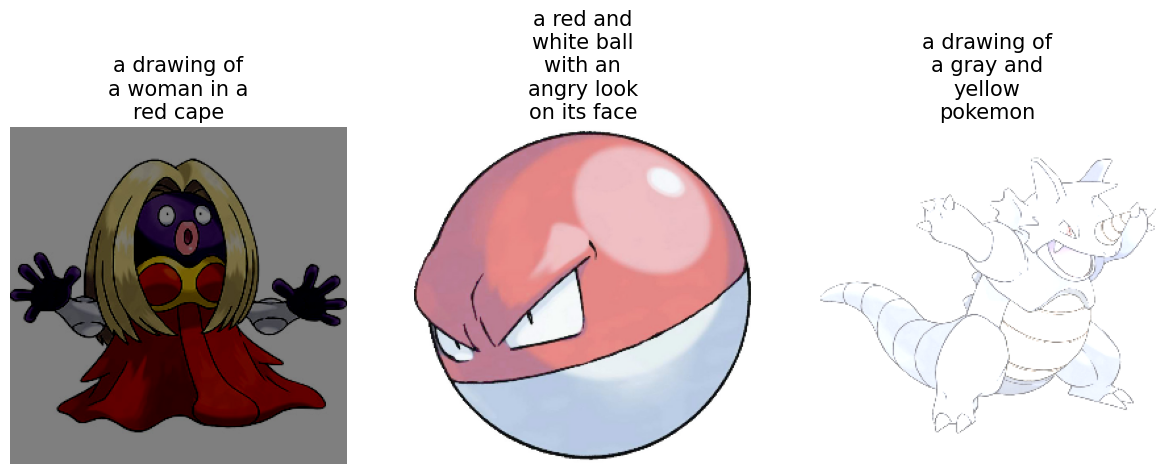

In [11]:
plt.figure(figsize=(20,20))
for i in range(3):
    ax = plt.subplot(1,4, i+ 1)
    plt.imshow((sample_batch['images'][i] + i) / 2)
    
    text = tokenizer.decode(sample_batch['tokens'][i].numpy().squeeze())
    text = text.replace('<|startoftext|>', '')
    text = text.replace('<|endoftext|>', '')
    text = '\n'.join(wrap(text, 12))
    plt.title(text, fontsize = 15)
    plt.axis('off')

## A trainer class for the fine-tuning loop

In [12]:

class Trainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        images = inputs["images"]
        encoded_text = inputs["encoded_text"]
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, encoded_text], training=True
            )
            loss = self.compiled_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_period = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_period * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )


One important implementation detail to note here: Instead of directly taking
the latent vector produced by the image encoder (which is a VAE), we sample from the
mean and log-variance predicted by it. This way, we can achieve better sample
quality and diversity.

It's common to add support for mixed-precision training along with exponential
moving averaging of model weights for fine-tuning these models. However, in the interest
of brevity, we discard those elements. More on this later in the tutorial.

## Initialize the trainer and compile it

In [13]:
# Enable mixed-precision training if the underlying GPU has tensor cores.
USE_MP = True
if USE_MP:
    keras.mixed_precision.set_global_policy('mixed_float16')
    
image_encoder = ImageEncoder()
diffusion_ft_trainer = Trainer(
    diffusion_model = DiffusionModel(RESOLUTION, RESOLUTION , MAX_PROMPT_LENGTH),
vae = tf.keras.Model(
    image_encoder.input,
    image_encoder.layers[-2].output,
),
noise_scheduler = NoiseScheduler(),
use_mixed_precision = USE_MP,
)
lr = 1e-5
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
diffusion_ft_trainer.compile(optimizer=optimizer, loss="mse")

3439090152/3439090152 [==============================] - 20s 0us/step


## Fine Tune

To keep the runtime of this tutorial short, we just fine-tune for an epoch.

In [ ]:
epochs = 1
ckpt_path = "finetuned_stable_diffusion.h5"
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
diffusion_ft_trainer.fit(training_dataset, epochs=epochs, callbacks=[ckpt_callback])

## Inference

We fine-tuned the model for 60 epochs on an image resolution of 512x512. To allow
training with this resolution, we incorporated mixed-precision support. You can
check out
[this repository](https://github.com/sayakpaul/stabe-diffusion-keras-ft)
for more details. It additionally provides support for exponential moving averaging of
the fine-tuned model parameters and model checkpointing.


For this section, we'll use the checkpoint derived after 60 epochs of fine-tuning.

In [ ]:
weights_path = tf.keras.utils.get_file(
    origin="https://huggingface.co/sayakpaul/kerascv_sd_pokemon_finetuned/resolve/main/ckpt_epochs_72_res_512_mp_True.h5"
)

img_height = img_width = 512
pokemon_model = keras_cv.models.StableDiffusion(
    img_width=img_width, img_height=img_height
)
# We just reload the weights of the fine-tuned diffusion model.
pokemon_model.diffusion_model.load_weights(weights_path)

Now, we can take this model for a test-drive.

In [ ]:
prompts = ["Yoda", "Hello Kitty", "A pokemon with red eyes"]
images_to_generate = 3
outputs = {}

for prompt in prompts:
    generated_images = pokemon_model.text_to_image(
        prompt, batch_size=images_to_generate, unconditional_guidance_scale=40
    )
    outputs.update({prompt: generated_images})

With 60 epochs of fine-tuning (a good number is about 70), the generated images were not
up to the mark. So, we experimented with the number of steps Stable Diffusion takes
during the inference time and the `unconditional_guidance_scale` parameter.

We found the best results with this checkpoint with `unconditional_guidance_scale` set to
40.

In [ ]:

def plot_images(images, title):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(title, fontsize=12)
        plt.axis("off")


for prompt in outputs:
    plot_images(outputs[prompt], prompt)